# Load data
## This notebook uses data augmentations (v2 transforms) to produce unique batches of data at each epoch

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.backends.cudnn.benchmark = True

train_data_dir = r"../datasets/playing_cards/train"
valid_data_dir = r"../datasets/playing_cards/valid"
test_data_dir = r"../datasets/playing_cards/test"

cuda


In [4]:
from torch.utils.data import DataLoader
from core.dataloaders.images_dataset import ImageDataset
import torchvision.transforms.v2 as transforms
from shared_modules.display_engine import DisplayImages

size = (224, 224)
# setting up transformation
# no augmentation for validation and test
transformation = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(size, antialias=True)
])

# augmentation for training
augmentation = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(size, antialias=True),
        # we can use random choice to apply random transformations, identify when using raw image
        # flip/rotations transforms
        transforms.RandomChoice([
            transforms.RandomVerticalFlip(p=1),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation(degrees=45),
            torch.nn.Identity(),            
        ]),
        # affine transforms
        transforms.RandomChoice([
            transforms.RandomAffine(degrees = 0, translate = (0., 0.2)),
            torch.nn.Identity(),            
        ]),
        # color transforms
        transforms.RandomChoice([
            transforms.RandomAdjustSharpness(sharpness_factor=2),
            transforms.RandomEqualize(p=1),
            transforms.RandomPosterize(bits=2, p=1),
            transforms.RandomInvert(p=1),
            torch.nn.Identity(),            
        ]),
        # Gaussian noise
        transforms.RandomChoice([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.001, 0.1))          
        ]),

])
# creating dataset
train_dataset = ImageDataset(
    data_dir=train_data_dir,
    transform=augmentation
)
valid_dataset = ImageDataset(
    data_dir=valid_data_dir,
    transform=transformation
)

test_dataset = ImageDataset(
    data_dir=test_data_dir,
    transform=transformation
)

classes = train_dataset.classes
print(classes)

# creating dataloader
workers = 8
prefetch = 8
batch_size = 32*3
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers,
                              prefetch_factor=prefetch,
                              persistent_workers=True,
                              pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=workers,
                              prefetch_factor= prefetch,
                              persistent_workers=True,
                              pin_memory=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=0,
                             persistent_workers=False,
                             pin_memory=False)

print("training set", len(train_dataloader.dataset))
print("valid set", len(valid_dataloader.dataset))
print("test set", len(test_dataloader.dataset))

# iterating over the dataset to see transforms
# for _ in range(10):     
#     for idx, (image, label) in enumerate(train_dataloader):
#         print("shapes:")
#         print(image.shape)
#         print(label.shape)
#         DisplayImages.display_image(image, label)
#         if idx == 0:
#             break

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
training set 7624
valid set 265
test set 

# Model

In [5]:
from core.classifier_models.simplevit import SimpleVitClassifier
model = SimpleVitClassifier(image_size = (3, 224, 224),
                            patch_size = 16,
                            channels = 3,
                            num_classes = 53,
                            depth=8,
                            heads=12,
                            mlp_dim= 256)

In [6]:
# create optimizer and loss function
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# create wrapper
from core.wrappers.wrapper import Wrapper
classifier = Wrapper(model = model, optimizer= optimizer, criterion= criterion, device = "cuda")

In [8]:
# from torchinfo import summary
# input_size = (3, 224, 224)
# summary(model=classifier.model,
#         input_size=input_size,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [9]:
num_epochs = 150
classifier.fit(epochs=num_epochs, train_dataloader = train_dataloader, valid_dataloader=valid_dataloader)

Epochs::   0%|          | 0/150 [00:00<?, ?it/s]

| Epoch 1/150 | T-loss: 3.949 | V-loss: 3.771 |T-acc: 0.03 |V-acc: 0.03
| Epoch 2/150 | T-loss: 3.687 | V-loss: 3.466 |T-acc: 0.06 |V-acc: 0.05
| Epoch 3/150 | T-loss: 3.475 | V-loss: 3.221 |T-acc: 0.07 |V-acc: 0.08
| Epoch 4/150 | T-loss: 3.314 | V-loss: 3.081 |T-acc: 0.10 |V-acc: 0.10
| Epoch 5/150 | T-loss: 3.229 | V-loss: 2.926 |T-acc: 0.10 |V-acc: 0.14
| Epoch 6/150 | T-loss: 3.128 | V-loss: 2.830 |T-acc: 0.13 |V-acc: 0.15
| Epoch 7/150 | T-loss: 3.043 | V-loss: 2.710 |T-acc: 0.14 |V-acc: 0.18
| Epoch 8/150 | T-loss: 2.931 | V-loss: 2.554 |T-acc: 0.16 |V-acc: 0.19
| Epoch 9/150 | T-loss: 2.850 | V-loss: 2.461 |T-acc: 0.19 |V-acc: 0.28
| Epoch 10/150 | T-loss: 2.751 | V-loss: 2.337 |T-acc: 0.22 |V-acc: 0.29
| Epoch 11/150 | T-loss: 2.704 | V-loss: 2.276 |T-acc: 0.23 |V-acc: 0.32
| Epoch 12/150 | T-loss: 2.647 | V-loss: 2.245 |T-acc: 0.25 |V-acc: 0.31
| Epoch 13/150 | T-loss: 2.597 | V-loss: 2.131 |T-acc: 0.25 |V-acc: 0.38
| Epoch 14/150 | T-loss: 2.511 | V-loss: 2.060 |T-acc: 0.29 

C:\Users\agarc\anaconda3\envs\ViT_py311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 2, 0, 3, 3, 3, 3, 4, 4, 44, 4, 4, 5, 5, 5, 5, 5, 6, 6, 2, 6, 6, 7, 7, 7, 7, 7, 8, 0, 12, 0, 8, 9, 9, 9, 5, 9, 10, 10, 10, 9, 10, 11, 11, 11, 28, 11, 12, 12, 12, 37, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 2, 15, 40, 15, 12, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 23, 18, 18, 18, 42, 19, 32, 19, 19, 29, 32, 7, 44, 48, 21, 21, 16, 21, 21, 22, 22, 2, 22, 22, 23, 23, 23, 23, 23, 24, 37, 24, 21, 24, 25, 4, 25, 25, 4, 26, 2, 26, 26, 26, 27, 27, 27, 42, 27, 28, 28, 36, 28, 28, 32, 29, 29, 32, 30, 30, 30, 22, 13, 30, 31, 31, 31, 30, 31, 32, 32, 32, 32, 24, 33, 33, 33, 33, 33, 34, 34, 27, 34, 34, 35, 35, 35, 34, 35, 36, 36, 36, 42, 36, 31, 41, 37, 25, 0, 38, 39, 38, 38, 38, 35, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 42, 41, 41, 41, 42, 42, 42, 42, 42, 43, 14, 43, 43, 43, 44, 44, 44, 15, 44, 45, 45, 45, 8, 49, 46, 46, 46, 46, 46, 47, 46, 47, 47, 47, 48, 48, 48, 48, 48, 45, 49, 3, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 2, 50, 52, 3, 52, 52, 4]


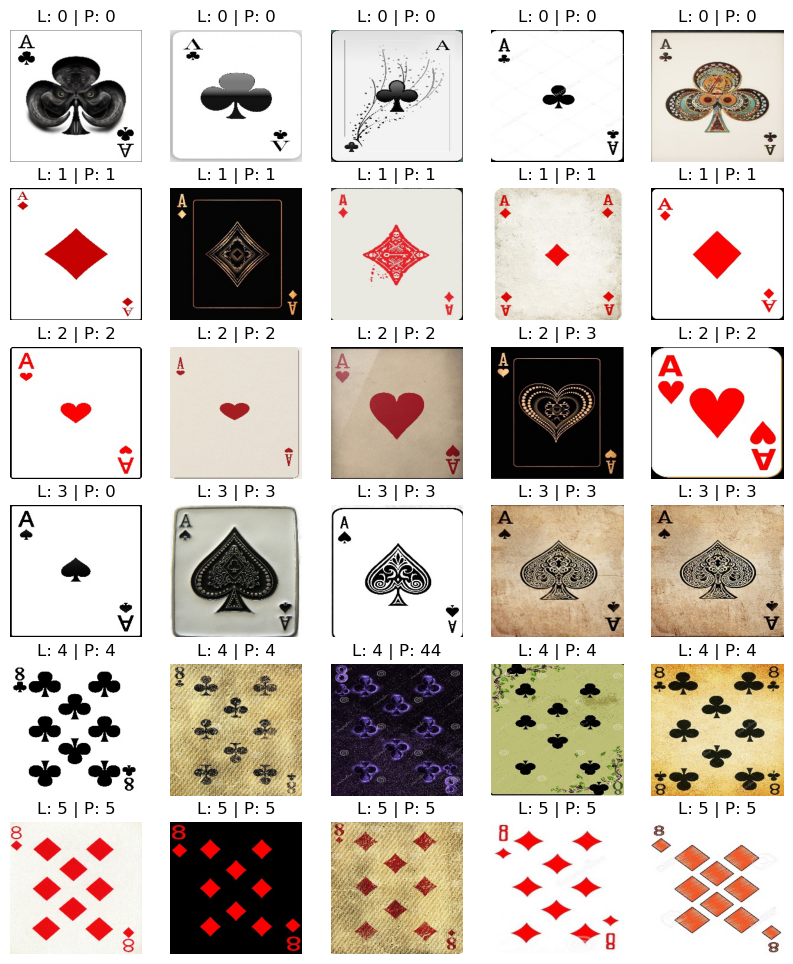

[2, 6, 6, 7, 7, 7, 7, 7, 8, 0, 12, 0, 8, 9, 9, 9, 5, 9, 10, 10, 10, 9, 10, 11, 11, 11, 28, 11, 12, 12, 12, 37]


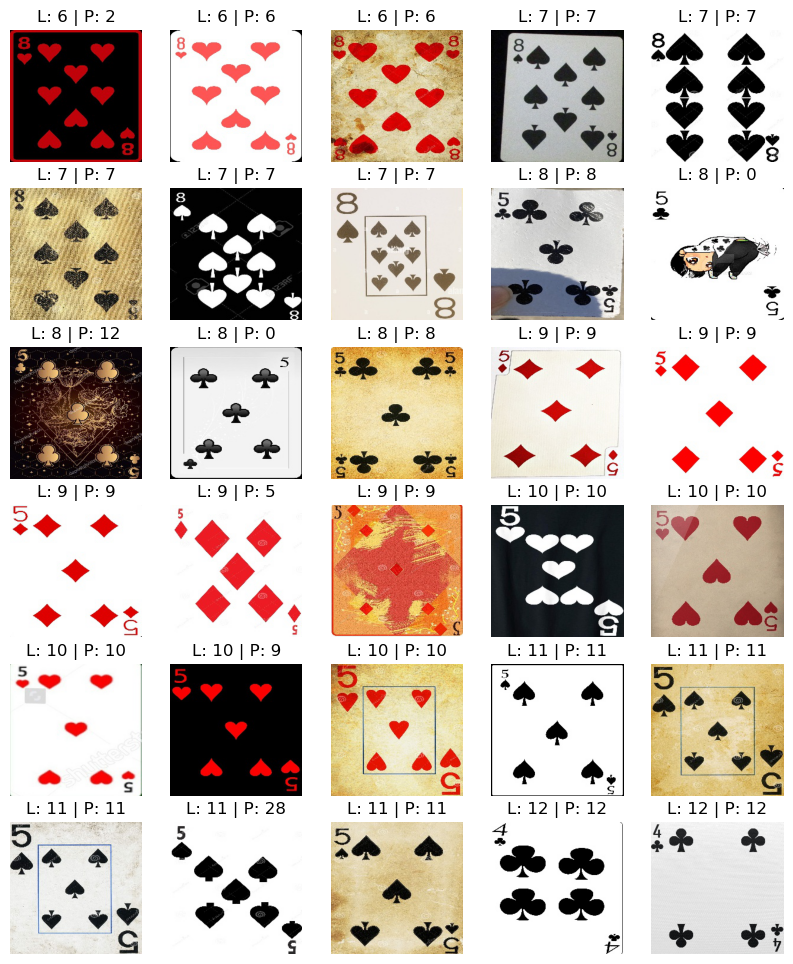

[12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 2, 15, 40, 15, 12, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 23, 18, 18, 18, 42]


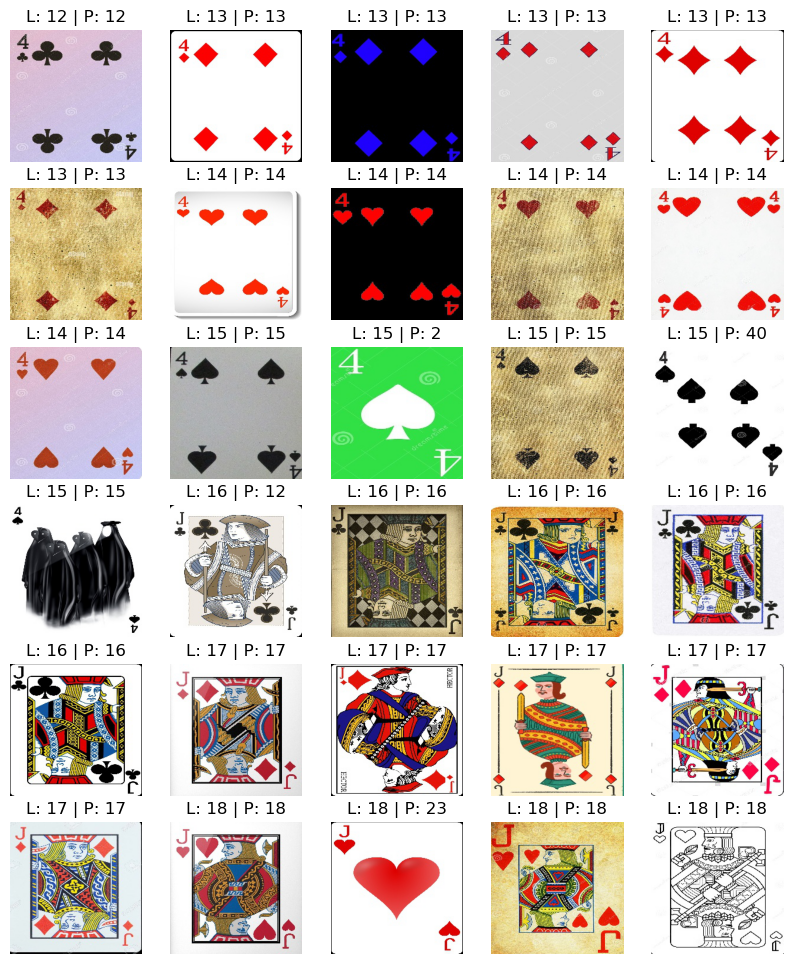

[19, 32, 19, 19, 29, 32, 7, 44, 48, 21, 21, 16, 21, 21, 22, 22, 2, 22, 22, 23, 23, 23, 23, 23, 24, 37, 24, 21, 24, 25, 4, 25]


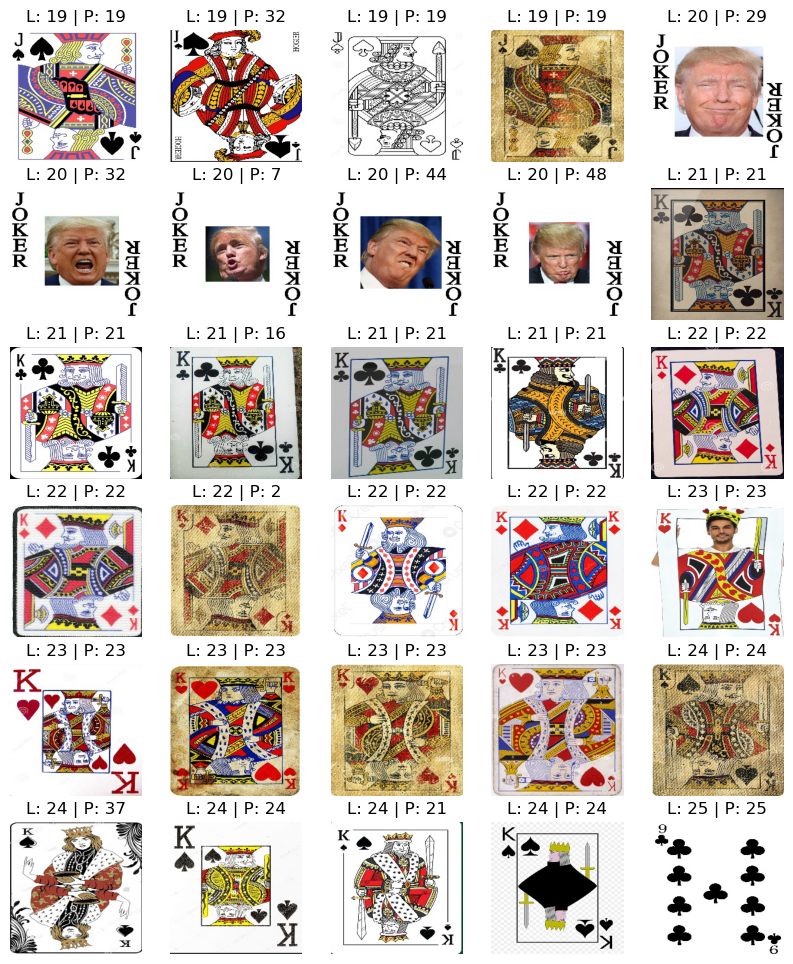

[25, 4, 26, 2, 26, 26, 26, 27, 27, 27, 42, 27, 28, 28, 36, 28, 28, 32, 29, 29, 32, 30, 30, 30, 22, 13, 30, 31, 31, 31, 30, 31]


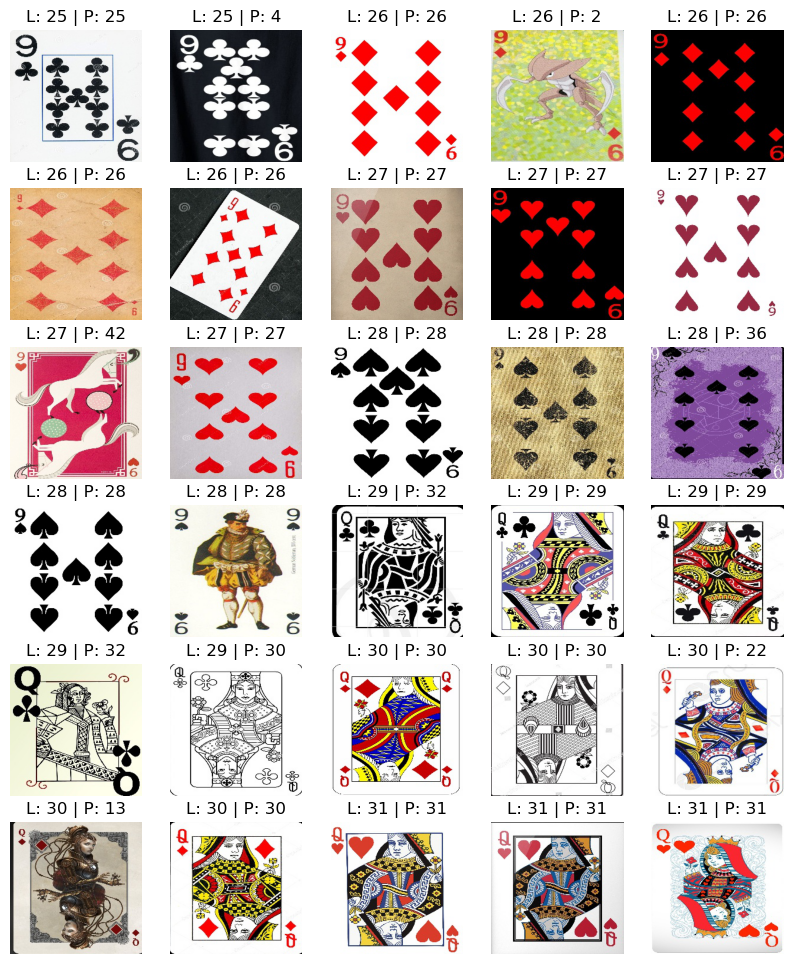

[32, 32, 32, 32, 24, 33, 33, 33, 33, 33, 34, 34, 27, 34, 34, 35, 35, 35, 34, 35, 36, 36, 36, 42, 36, 31, 41, 37, 25, 0, 38, 39]


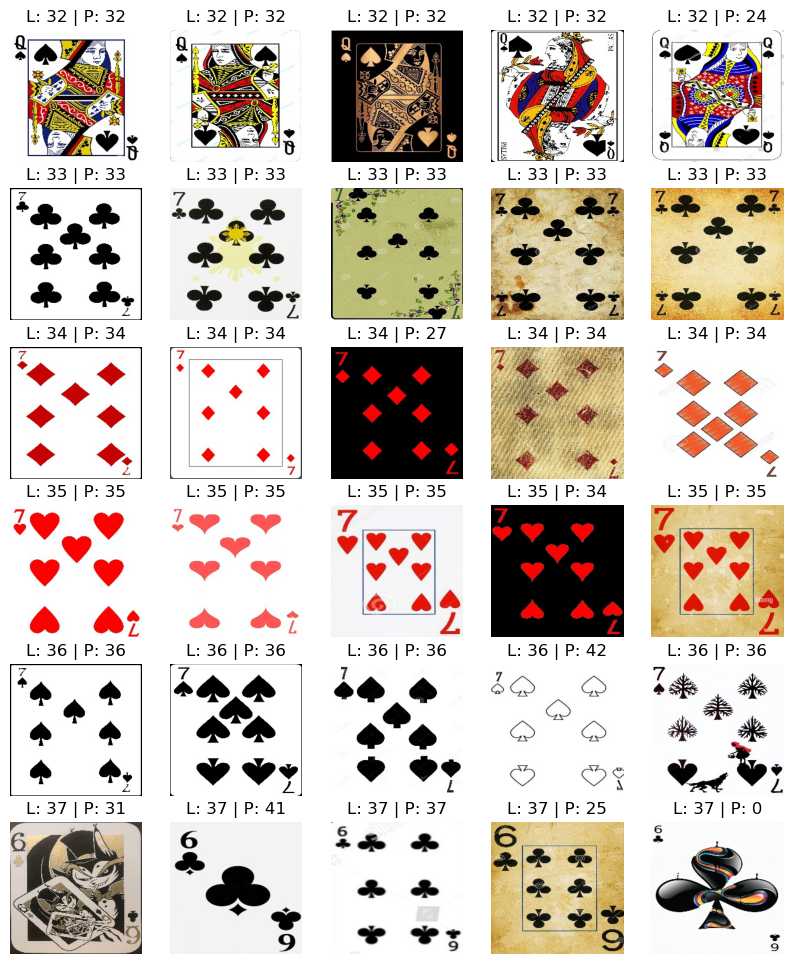

[38, 38, 38, 35, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 42, 41, 41, 41, 42, 42, 42, 42, 42, 43, 14, 43, 43, 43, 44, 44, 44, 15]


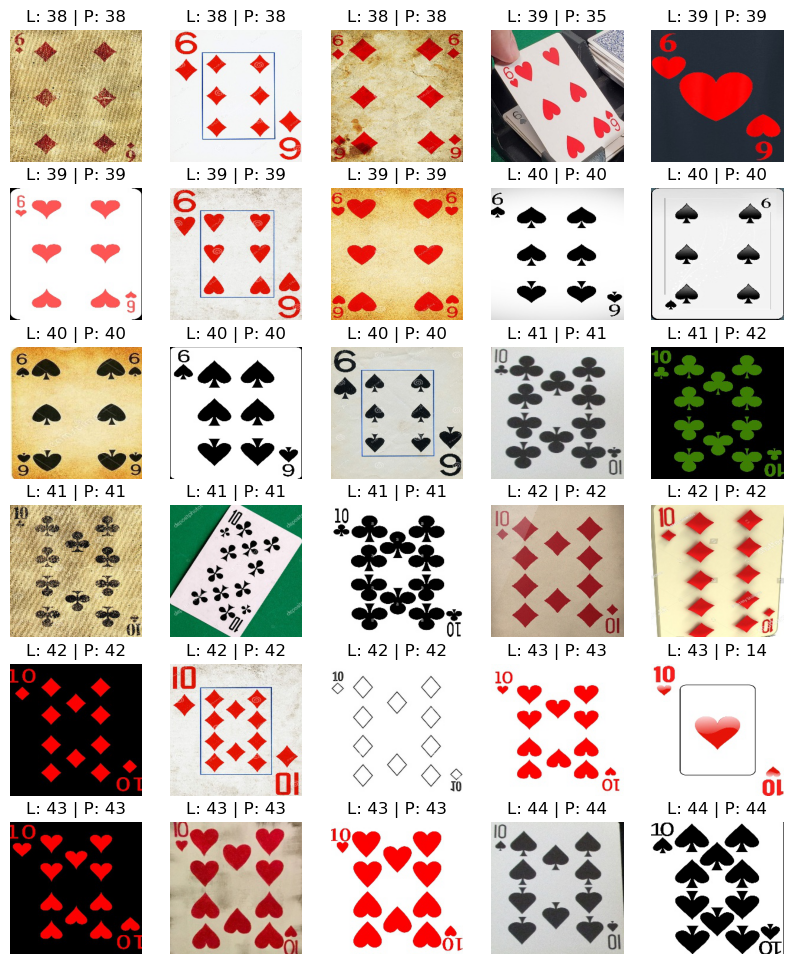

[44, 45, 45, 45, 8, 49, 46, 46, 46, 46, 46, 47, 46, 47, 47, 47, 48, 48, 48, 48, 48, 45, 49, 3, 49, 49, 50, 50, 50, 50, 50, 51]


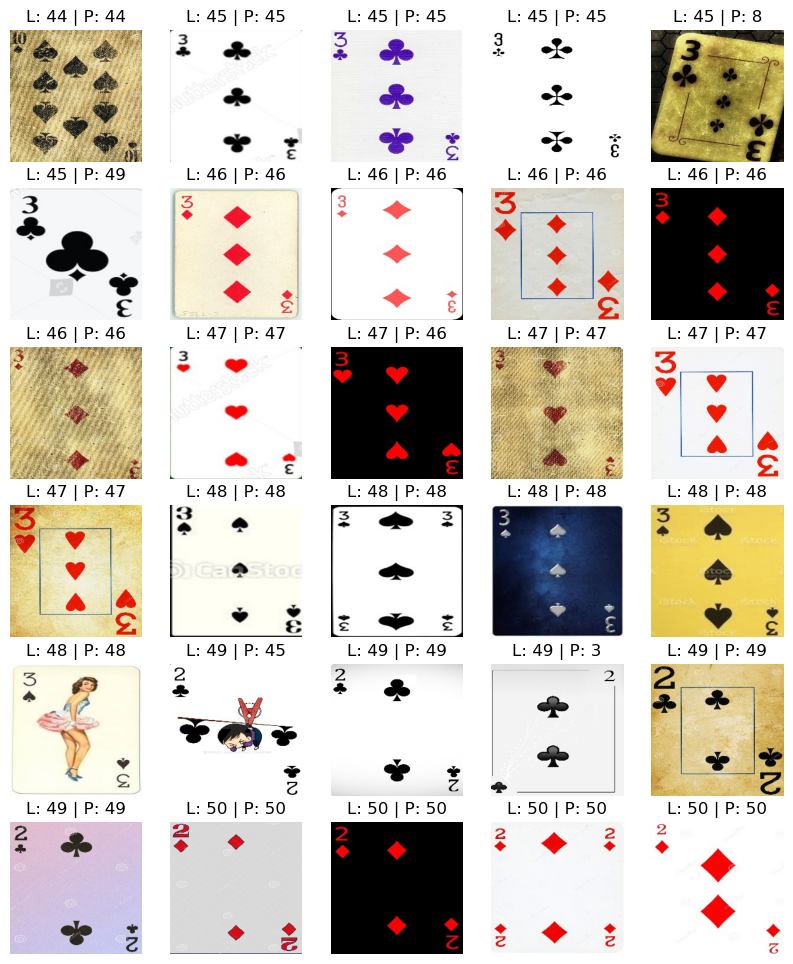

[51, 51, 2, 50, 52, 3, 52, 52, 4]


IndexError: index 9 is out of bounds for dimension 0 with size 9

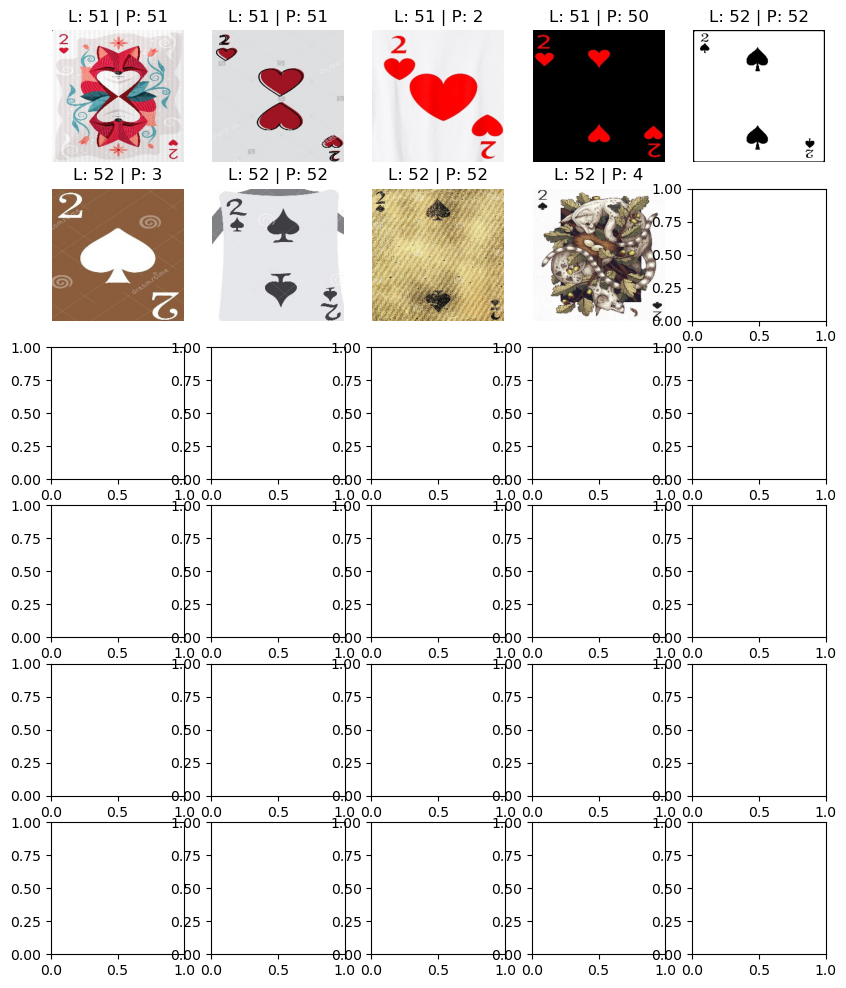

In [10]:
# model accuracy post training
predictions = classifier.predict_class(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)

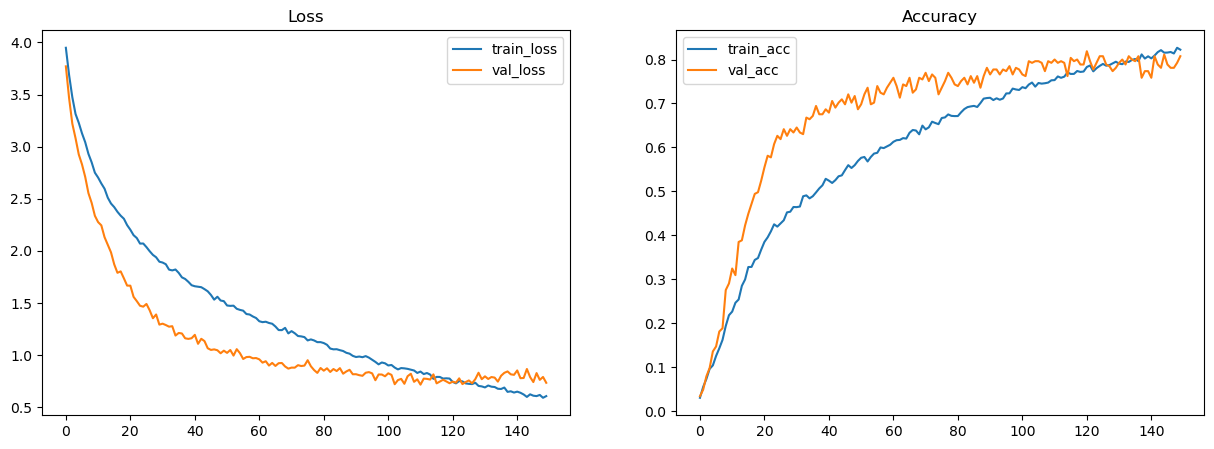

In [11]:
from shared_modules.display_engine import DisplayMetrics

DisplayMetrics.display_metrics(classifier.train_losses,
                               classifier.val_losses,
                               classifier.train_acc,
                               classifier.val_acc)

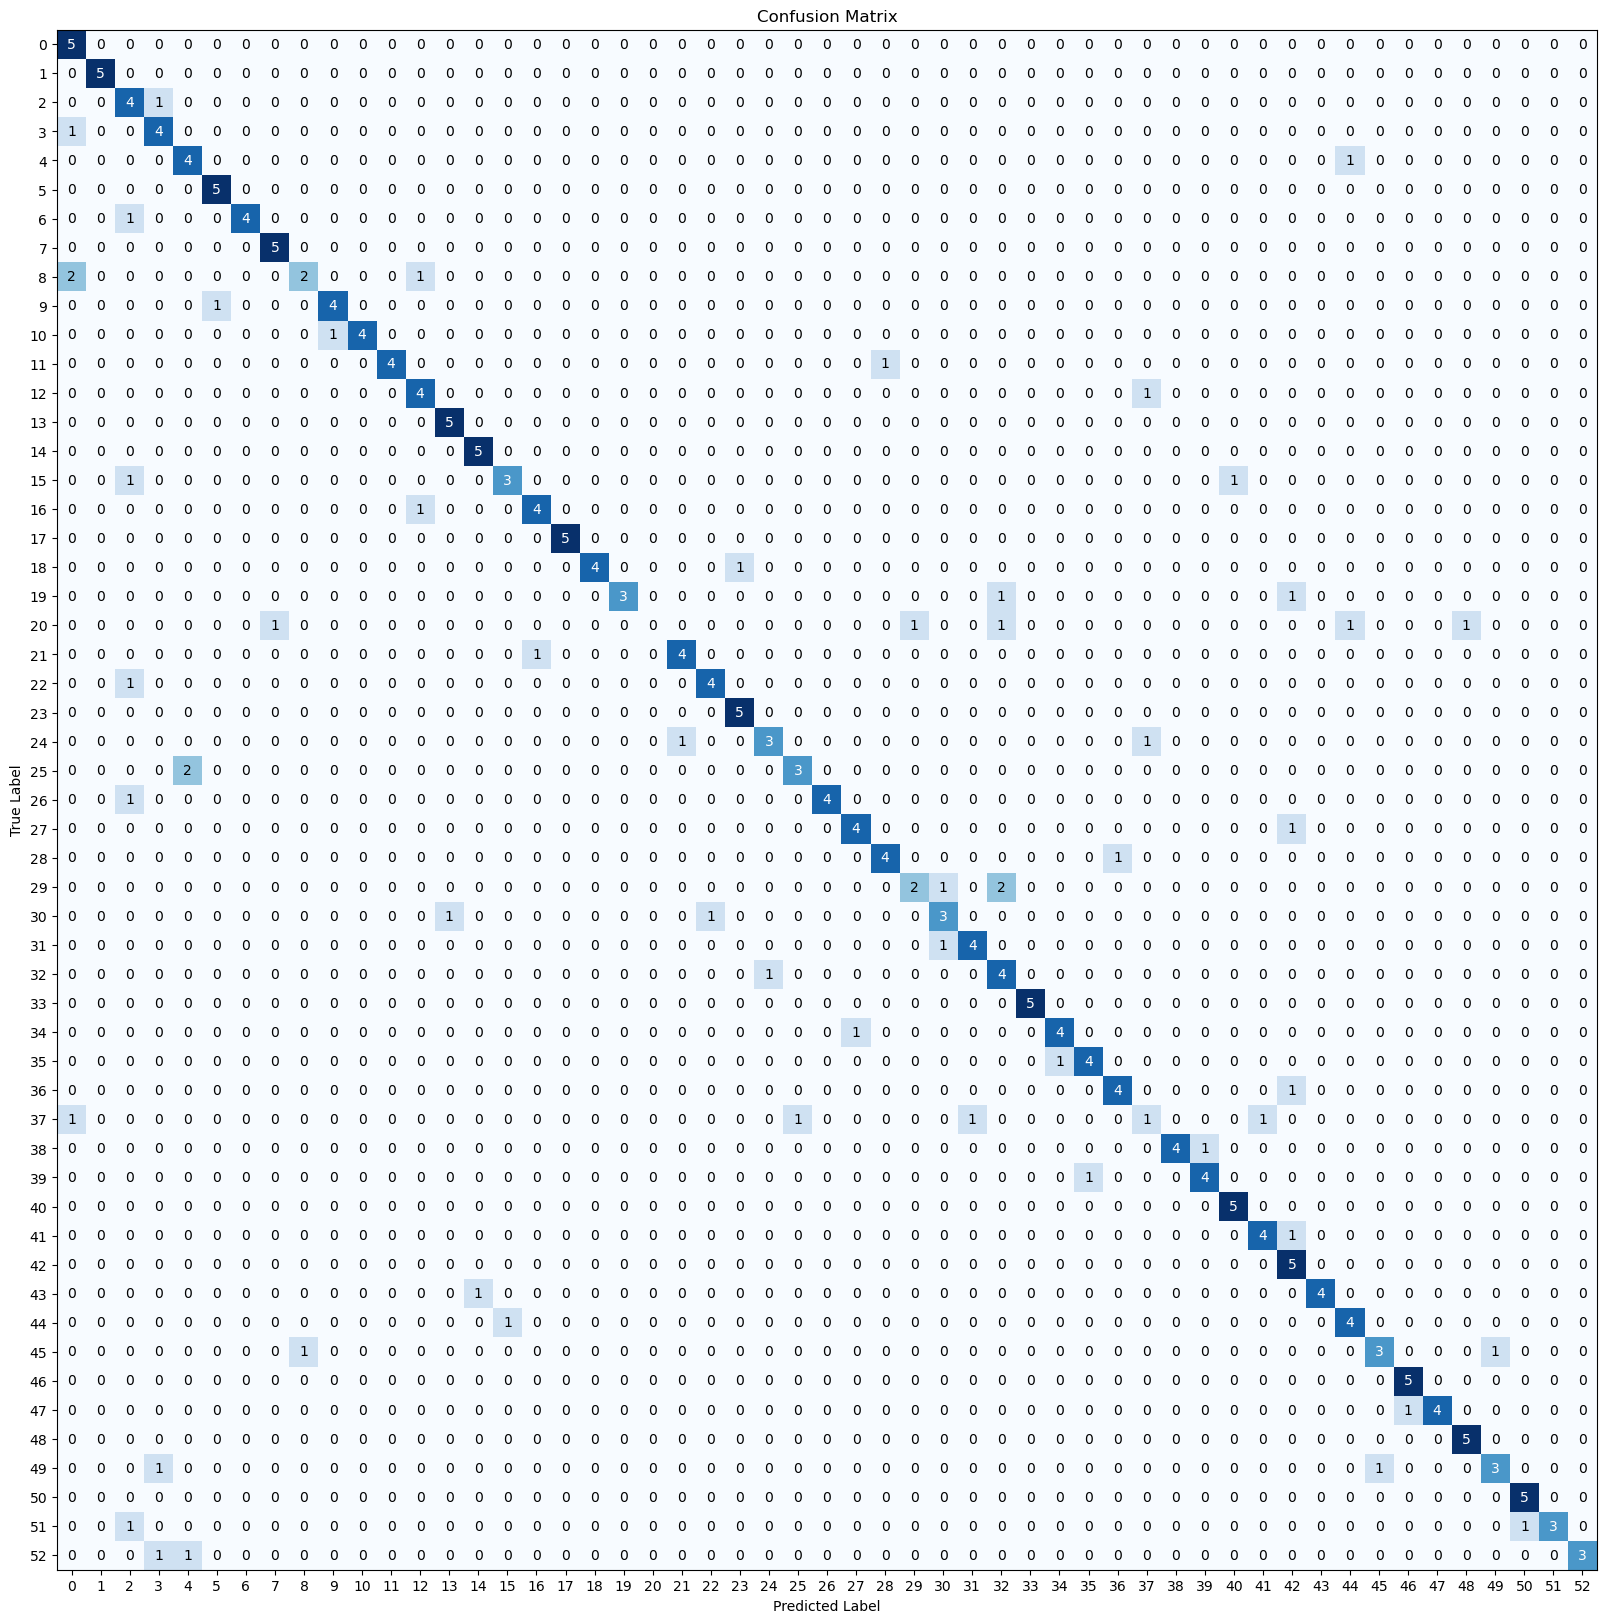

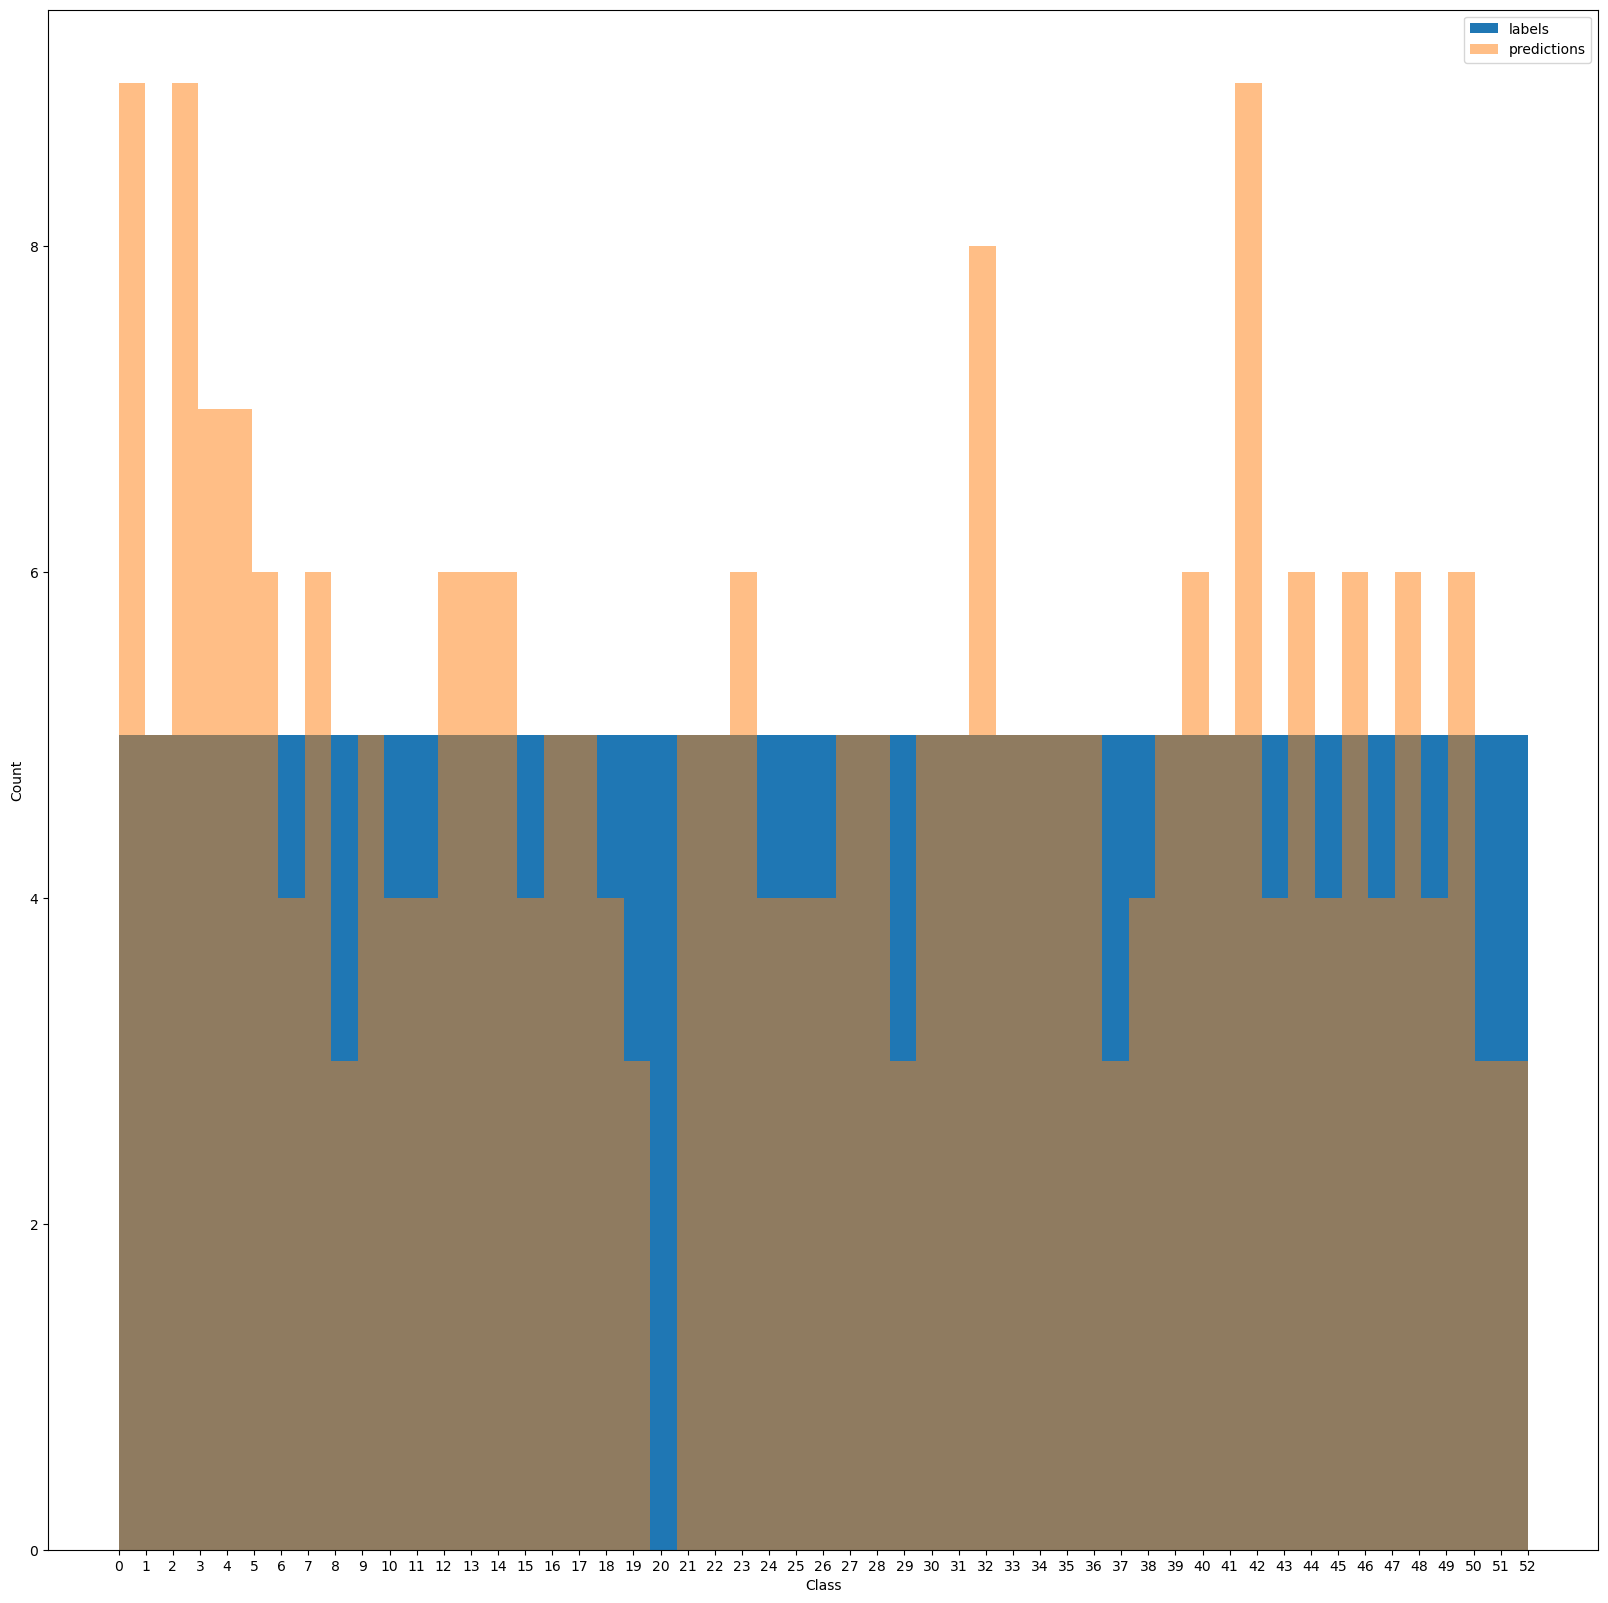

In [12]:
from shared_modules.display_engine import DisplayMetrics

labels = []
class_preds = []
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    labels.extend(label.numpy())
    class_preds.extend(class_pred)

DisplayMetrics.confusion_matrix(labels, class_preds, (20, 20))
DisplayMetrics.prediction_distribution(labels, class_preds, (20, 20))